In [4]:
!pip install torch_geometric umap-learn trimap memory_profiler

In [2]:
params_dict = {
    "Cora_gnn": {
        "tSNE": {"metric": "cosine", "n_iter": 2000, "perplexity": 30, "learning_rate": 100},
        "UMAP": {"metric": "cosine", "min_dist": 0.1, "n_neighbors": 20},
        "TRIMAP": {"metric": "cosine", "n_inliers": 30, "n_iters": 400, "n_outliers": 4, "n_random": 3}
    },
    "Cora_original": {
        "tSNE": {"metric": "cosine", "n_iter": 2000, "perplexity": 50, "learning_rate": 500},
        "UMAP": {"metric": "cosine", "min_dist": 0.1, "n_neighbors": 20},
        "TRIMAP": {"metric": "manhattan", "n_inliers": 12, "n_iters": 2000, "n_outliers": 2, "n_random": 1}
    },
    "Amazon_gnn": {
        "tSNE": {"metric": "cosine", "n_iter": 2000, "perplexity": 50, "learning_rate": 500},
        "UMAP": {"metric": "cosine", "min_dist": 0.25, "n_neighbors": 30},
        "TRIMAP": {"metric": "manhattan", "n_inliers": 30, "n_iters": 2000, "n_outliers": 12, "n_random": 1}
    },
    "Amazon_original": {
        "tSNE": {"metric": "cosine", "n_iter": 2000, "perplexity": 50, "learning_rate": 500},
        "UMAP": {"metric": "cosine", "min_dist": 0.25, "n_neighbors": 30},
        "TRIMAP": {"metric": "manhattan", "n_inliers": 6, "n_iters": 1000, "n_outliers": 2, "n_random": 1}
    },
    "Coauthor_gnn": {
        "tSNE": {"metric": "cosine", "n_iter": 1000, "perplexity": 100, "learning_rate": 500},
        "UMAP": {"metric": "cosine", "min_dist": 0.1, "n_neighbors": 20},
        "TRIMAP": {"metric": "cosine", "n_inliers": 30, "n_iters": 1000, "n_outliers": 8, "n_random": 1}
    },
    "Coauthor_original": {
        "tSNE": {"metric": "cosine", "n_iter": 1000, "perplexity": 100, "learning_rate": 500},
        "UMAP": {"metric": "cosine", "min_dist": 0.1, "n_neighbors": 20},
        "TRIMAP": {"metric": "cosine", "n_inliers": 16, "n_iters": 1000, "n_outliers": 2, "n_random": 6}
    },
}

Training GNN...
GNN Training Time: 3.09 seconds
RAM Memory usage: Current=0.06MB, Peak=0.07MB
GPU Memory usage: 1.06MB
t-SNE (Cora_original) Time: 50.56 seconds
t-SNE (Cora_original) RAM Memory usage: Current=0.04MB, Peak=90.31MB
t-SNE (Cora_original) GPU Memory usage: 0.00MB
UMAP (Cora_original) Time: 36.63 seconds
UMAP (Cora_original) RAM Memory usage: Current=10.55MB, Peak=127.05MB
UMAP (Cora_original) GPU Memory usage: -0.70MB
TRIMAP (Cora_original) Time: 14.65 seconds
TRIMAP (Cora_original) RAM Memory usage: Current=1.07MB, Peak=32.44MB
TRIMAP (Cora_original) GPU Memory usage: 0.00MB
t-SNE (Cora_gnn) Time: 40.66 seconds
t-SNE (Cora_gnn) RAM Memory usage: Current=0.05MB, Peak=87.83MB
t-SNE (Cora_gnn) GPU Memory usage: 0.00MB
UMAP (Cora_gnn) Time: 23.35 seconds
UMAP (Cora_gnn) RAM Memory usage: Current=11.06MB, Peak=112.41MB
UMAP (Cora_gnn) GPU Memory usage: 0.00MB
TRIMAP (Cora_gnn) Time: 18.70 seconds
TRIMAP (Cora_gnn) RAM Memory usage: Current=5.12MB, Peak=12.90MB
TRIMAP (Cora_gnn

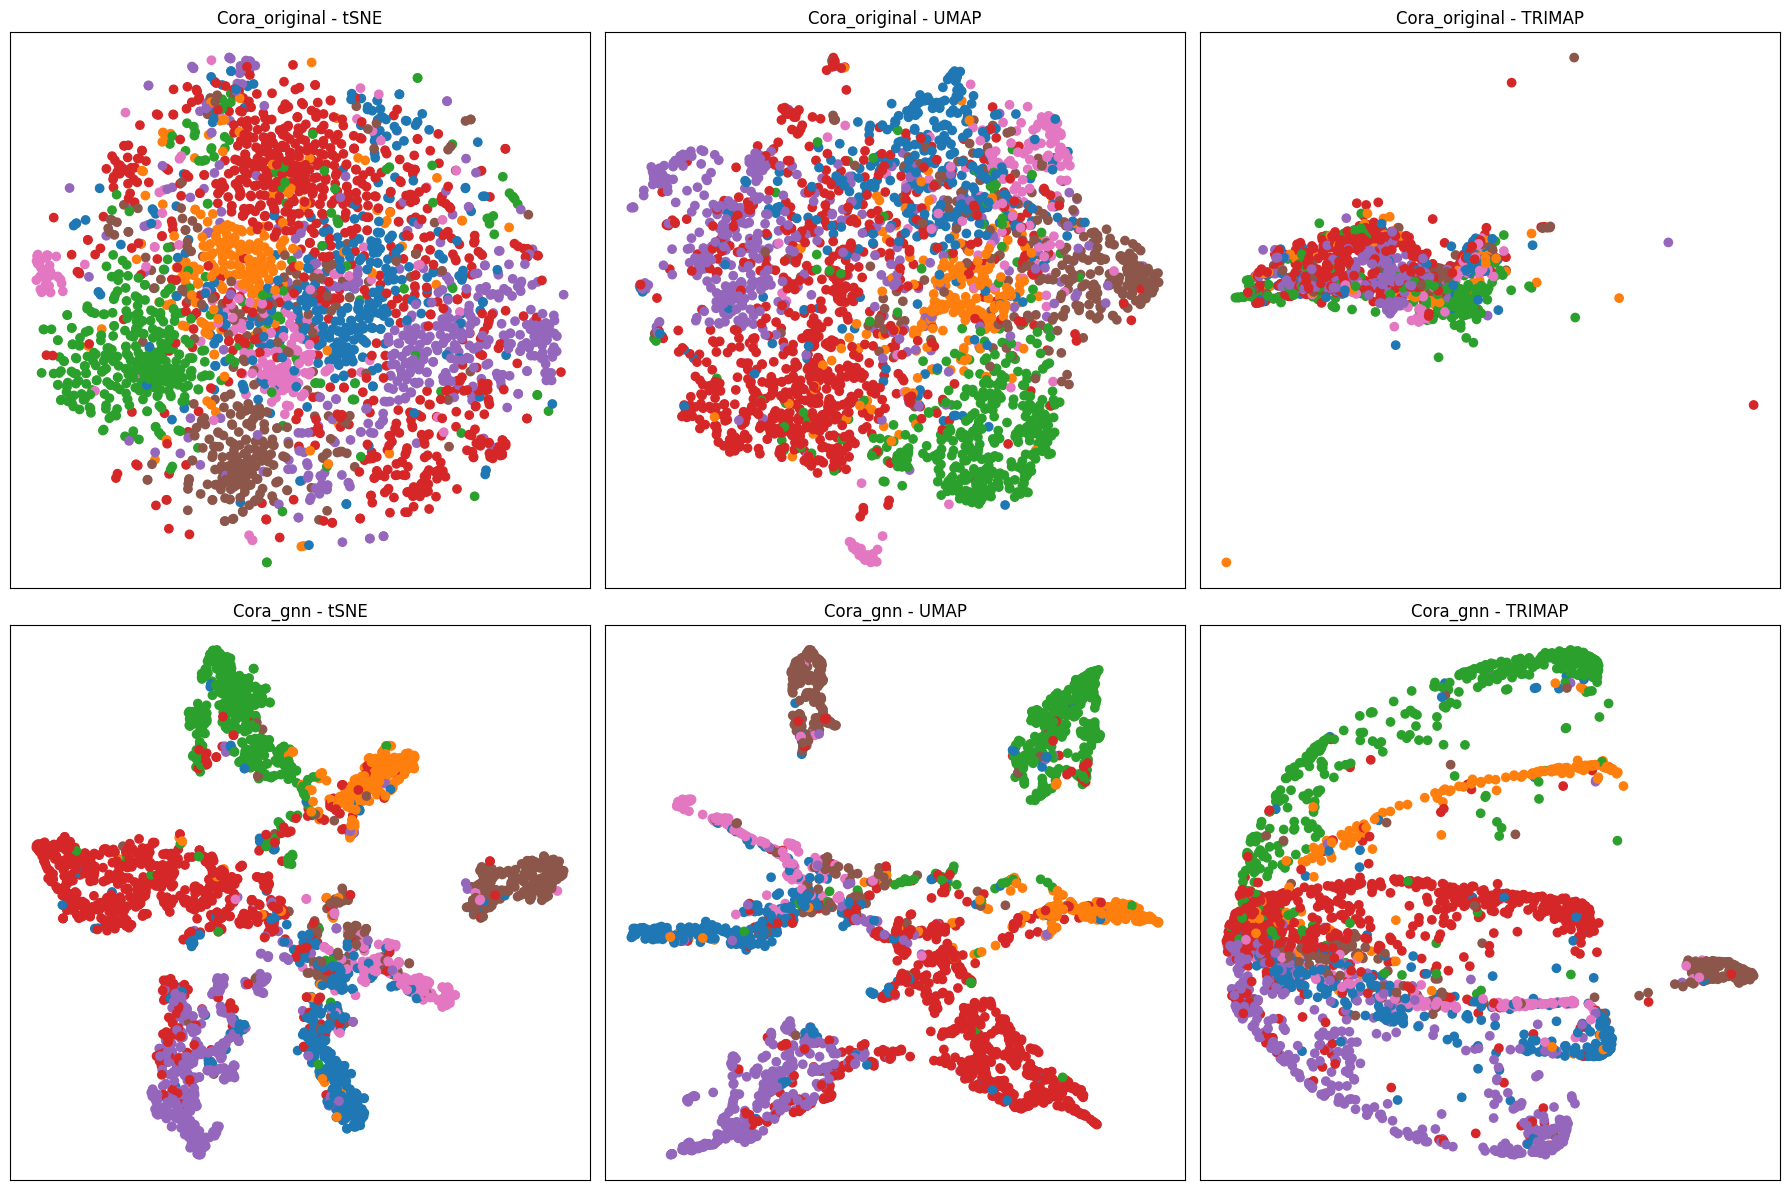

In [ ]:
import time
import numpy as np
import torch
from sklearn.manifold import TSNE
import umap
import trimap
import tracemalloc
from memory_profiler import memory_usage
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
from torch_geometric.data import Data
from torch_geometric.utils import train_test_split_edges
from torch_geometric.nn import GCNConv, GAE
from utils import *
from metrics import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to measure GPU memory usage
def get_gpu_memory():
    return torch.cuda.memory_allocated() / (1024 * 1024)

# Sample data for illustration, replace these with actual data loading and processing
def load_data():
    dataset = Planetoid(root='.', name='Cora', transform=None)
    data = dataset[0]
    return data.x.numpy(), data.y.numpy()

def load_gnn_output():
    dataset = Planetoid(root='.', name='Cora', transform=None)
    data = dataset[0].to(device)

    model = GCN(input_dim=dataset.num_node_features, hidden_dim=64, output_dim=16).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Training the GAE model to encode node features into 2D
    print("Training GNN...")
    tracemalloc.start()
    start_time = time.time()
    start_gpu_memory = get_gpu_memory()

    train_loop(200, model, optimizer, data)

    end_time = time.time()
    end_gpu_memory = get_gpu_memory()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    print(f"GNN Training Time: {end_time - start_time:.2f} seconds")
    print(f"RAM Memory usage: Current={current / 1024 / 1024:.2f}MB, Peak={peak / 1024 / 1024:.2f}MB")
    print(f"GPU Memory usage: {end_gpu_memory - start_gpu_memory:.2f}MB")

    # Extract features with the trained GNN
    model.eval()
    with torch.no_grad():
        gnn_output = model(data)

    # Move the features to CPU
    gnn_output = gnn_output.cpu().numpy()

    return gnn_output, data.y.cpu().numpy()



# Load datasets
cora_data, cora_labels = load_data()
gnn_output, gnn_labels = load_gnn_output()


# Initialize subplot
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# Function to apply dimensionality reduction and plot
def apply_dr_and_plot(dataset_name, data, labels, row):
    # tSNE
    tsne_params = params_dict[f"{dataset_name}"]["tSNE"]
    tracemalloc.start()
    start_time = time.time()
    start_gpu_memory = get_gpu_memory()

    tsne = TSNE(metric=tsne_params["metric"], n_iter=tsne_params["n_iter"], perplexity=tsne_params["perplexity"], learning_rate=tsne_params["learning_rate"])
    tsne_results = tsne.fit_transform(data)

    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    end_gpu_memory = get_gpu_memory()
    end_time = time.time()

    print(f"t-SNE ({dataset_name}) Time: {end_time - start_time:.2f} seconds")
    print(f"t-SNE ({dataset_name}) RAM Memory usage: Current={current / 1024 / 1024:.2f}MB, Peak={peak / 1024 / 1024:.2f}MB")
    print(f"t-SNE ({dataset_name}) GPU Memory usage: {end_gpu_memory - start_gpu_memory:.2f}MB")

    plot_no_show(axs[row, 0], tsne_results, labels, f"{dataset_name} - tSNE")

    # UMAP
    umap_params = params_dict[f"{dataset_name}"]["UMAP"]
    tracemalloc.start()
    start_time = time.time()
    start_gpu_memory = get_gpu_memory()

    umap_model = umap.UMAP(metric=umap_params["metric"], min_dist=umap_params["min_dist"], n_neighbors=umap_params["n_neighbors"])
    umap_results = umap_model.fit_transform(data)

    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    end_gpu_memory = get_gpu_memory()
    end_time = time.time()

    print(f"UMAP ({dataset_name}) Time: {end_time - start_time:.2f} seconds")
    print(f"UMAP ({dataset_name}) RAM Memory usage: Current={current / 1024 / 1024:.2f}MB, Peak={peak / 1024 / 1024:.2f}MB")
    print(f"UMAP ({dataset_name}) GPU Memory usage: {end_gpu_memory - start_gpu_memory:.2f}MB")

    plot_no_show(axs[row, 1], umap_results, labels, f"{dataset_name} - UMAP")

    # TRIMAP
    trimap_params = params_dict[f"{dataset_name}"]["TRIMAP"]
    tracemalloc.start()
    start_time = time.time()
    start_gpu_memory = get_gpu_memory()

    trimap_model = trimap.TRIMAP(distance=trimap_params["metric"], n_inliers=trimap_params["n_inliers"], n_iters=trimap_params["n_iters"], n_outliers=trimap_params["n_outliers"], n_random=trimap_params["n_random"])
    trimap_results = trimap_model.fit_transform(data)

    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    end_gpu_memory = get_gpu_memory()
    end_time = time.time()

    print(f"TRIMAP ({dataset_name}) Time: {end_time - start_time:.2f} seconds")
    print(f"TRIMAP ({dataset_name}) RAM Memory usage: Current={current / 1024 / 1024:.2f}MB, Peak={peak / 1024 / 1024:.2f}MB")
    print(f"TRIMAP ({dataset_name}) GPU Memory usage: {end_gpu_memory - start_gpu_memory:.2f}MB")

    plot_no_show(axs[row, 2], trimap_results, labels, f"{dataset_name} - TRIMAP")

# Process Cora_original
apply_dr_and_plot("Cora_original", cora_data, cora_labels, 0)

# Process Cora_gnn
apply_dr_and_plot("Cora_gnn", gnn_output, gnn_labels, 1)

# Adjust layout
plt.tight_layout()
plt.show()


Training GNN...
GNN Training Time: 14.41 seconds
RAM Memory usage: Current=0.06MB, Peak=0.08MB
GPU Memory usage: 0.58MB
t-SNE (Amazon_original) Time: 330.69 seconds
t-SNE (Amazon_original) RAM Memory usage: Current=0.23MB, Peak=1558.71MB
t-SNE (Amazon_original) GPU Memory usage: 0.00MB
UMAP (Amazon_original) Time: 147.39 seconds
UMAP (Amazon_original) RAM Memory usage: Current=139.56MB, Peak=375.21MB
UMAP (Amazon_original) GPU Memory usage: 0.00MB
TRIMAP (Amazon_original) Time: 52.51 seconds
TRIMAP (Amazon_original) RAM Memory usage: Current=3.85MB, Peak=91.87MB
TRIMAP (Amazon_original) GPU Memory usage: 0.00MB
t-SNE (Amazon_gnn) Time: 282.98 seconds
t-SNE (Amazon_gnn) RAM Memory usage: Current=0.12MB, Peak=1558.66MB
t-SNE (Amazon_gnn) GPU Memory usage: 0.00MB
UMAP (Amazon_gnn) Time: 44.89 seconds
UMAP (Amazon_gnn) RAM Memory usage: Current=29.84MB, Peak=180.53MB
UMAP (Amazon_gnn) GPU Memory usage: 0.00MB
TRIMAP (Amazon_gnn) Time: 652.19 seconds
TRIMAP (Amazon_gnn) RAM Memory usage: Cu

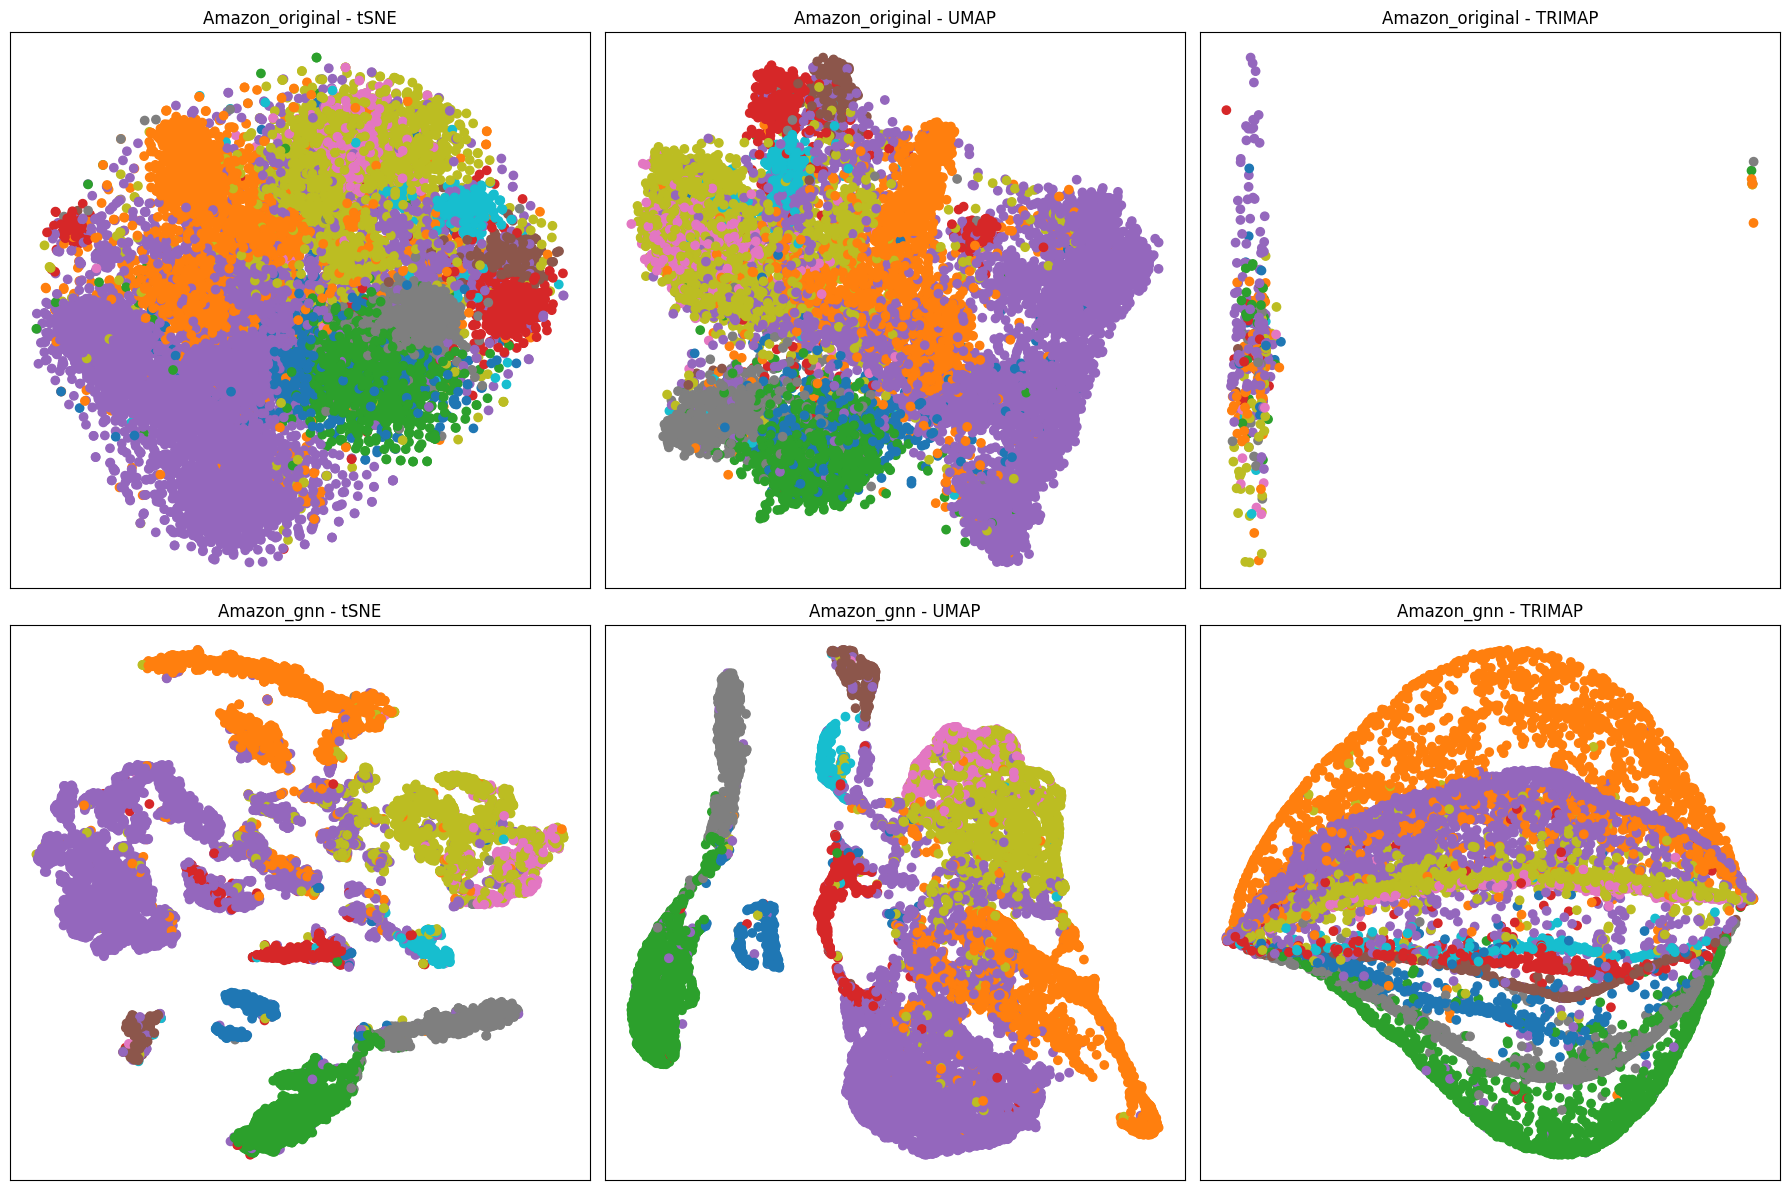

In [ ]:
import time
import numpy as np
import torch
from sklearn.manifold import TSNE
import umap
import trimap
import tracemalloc
from memory_profiler import memory_usage
import matplotlib.pyplot as plt
from torch_geometric.datasets import Amazon
from torch_geometric.data import Data
from torch_geometric.utils import train_test_split_edges
from torch_geometric.nn import GCNConv, GAE
from utils import *
from metrics import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to measure GPU memory usage
def get_gpu_memory():
    return torch.cuda.memory_allocated() / (1024 * 1024)

# Sample data for illustration, replace these with actual data loading and processing
def load_data():
    dataset = Amazon(root='.', name='Computers', transform=None)
    data = dataset[0]
    return data.x.numpy(), data.y.numpy()

def load_gnn_output():
    dataset = Amazon(root='.', name='Computers', transform=None)
    data = dataset[0].to(device)

    generate_train_test(data)

    model = GCN(input_dim=dataset.num_node_features, hidden_dim=64, output_dim=16).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Training the GAE model to encode node features into 2D
    print("Training GNN...")
    tracemalloc.start()
    start_time = time.time()
    start_gpu_memory = get_gpu_memory()

    train_loop(200, model, optimizer, data)

    end_time = time.time()
    end_gpu_memory = get_gpu_memory()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    print(f"GNN Training Time: {end_time - start_time:.2f} seconds")
    print(f"RAM Memory usage: Current={current / 1024 / 1024:.2f}MB, Peak={peak / 1024 / 1024:.2f}MB")
    print(f"GPU Memory usage: {end_gpu_memory - start_gpu_memory:.2f}MB")

    # Extract features with the trained GNN
    model.eval()
    with torch.no_grad():
        gnn_output = model(data)

    # Move the features to CPU
    gnn_output = gnn_output.cpu().numpy()

    return gnn_output, data.y.cpu().numpy()



# Load datasets
cora_data, cora_labels = load_data()
gnn_output, gnn_labels = load_gnn_output()


# Initialize subplot
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# Function to apply dimensionality reduction and plot
def apply_dr_and_plot(dataset_name, data, labels, row):
    # tSNE
    tsne_params = params_dict[f"{dataset_name}"]["tSNE"]
    tracemalloc.start()
    start_time = time.time()
    start_gpu_memory = get_gpu_memory()

    tsne = TSNE(metric=tsne_params["metric"], n_iter=tsne_params["n_iter"], perplexity=tsne_params["perplexity"], learning_rate=tsne_params["learning_rate"])
    tsne_results = tsne.fit_transform(data)

    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    end_gpu_memory = get_gpu_memory()
    end_time = time.time()

    print(f"t-SNE ({dataset_name}) Time: {end_time - start_time:.2f} seconds")
    print(f"t-SNE ({dataset_name}) RAM Memory usage: Current={current / 1024 / 1024:.2f}MB, Peak={peak / 1024 / 1024:.2f}MB")
    print(f"t-SNE ({dataset_name}) GPU Memory usage: {end_gpu_memory - start_gpu_memory:.2f}MB")

    plot_no_show(axs[row, 0], tsne_results, labels, f"{dataset_name} - tSNE")

    # UMAP
    umap_params = params_dict[f"{dataset_name}"]["UMAP"]
    tracemalloc.start()
    start_time = time.time()
    start_gpu_memory = get_gpu_memory()

    umap_model = umap.UMAP(metric=umap_params["metric"], min_dist=umap_params["min_dist"], n_neighbors=umap_params["n_neighbors"])
    umap_results = umap_model.fit_transform(data)

    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    end_gpu_memory = get_gpu_memory()
    end_time = time.time()

    print(f"UMAP ({dataset_name}) Time: {end_time - start_time:.2f} seconds")
    print(f"UMAP ({dataset_name}) RAM Memory usage: Current={current / 1024 / 1024:.2f}MB, Peak={peak / 1024 / 1024:.2f}MB")
    print(f"UMAP ({dataset_name}) GPU Memory usage: {end_gpu_memory - start_gpu_memory:.2f}MB")

    plot_no_show(axs[row, 1], umap_results, labels, f"{dataset_name} - UMAP")

    # TRIMAP
    trimap_params = params_dict[f"{dataset_name}"]["TRIMAP"]
    tracemalloc.start()
    start_time = time.time()
    start_gpu_memory = get_gpu_memory()

    trimap_model = trimap.TRIMAP(distance=trimap_params["metric"], n_inliers=trimap_params["n_inliers"], n_iters=trimap_params["n_iters"], n_outliers=trimap_params["n_outliers"], n_random=trimap_params["n_random"])
    trimap_results = trimap_model.fit_transform(data)

    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    end_gpu_memory = get_gpu_memory()
    end_time = time.time()

    print(f"TRIMAP ({dataset_name}) Time: {end_time - start_time:.2f} seconds")
    print(f"TRIMAP ({dataset_name}) RAM Memory usage: Current={current / 1024 / 1024:.2f}MB, Peak={peak / 1024 / 1024:.2f}MB")
    print(f"TRIMAP ({dataset_name}) GPU Memory usage: {end_gpu_memory - start_gpu_memory:.2f}MB")

    plot_no_show(axs[row, 2], trimap_results, labels, f"{dataset_name} - TRIMAP")

# Process Cora_original
apply_dr_and_plot("Amazon_original", cora_data, cora_labels, 0)

# Process Cora_gnn
apply_dr_and_plot("Amazon_gnn", gnn_output, gnn_labels, 1)

# Adjust layout
plt.tight_layout()
plt.show()


Processing...
Done!


Training GNN...
GNN Training Time: 10.59 seconds
RAM Memory usage: Current=0.17MB, Peak=0.20MB
GPU Memory usage: 22.43MB
t-SNE (Coauthor_original) Time: 1013.45 seconds
t-SNE (Coauthor_original) RAM Memory usage: Current=0.60MB, Peak=1838.46MB
t-SNE (Coauthor_original) GPU Memory usage: 0.00MB
UMAP (Coauthor_original) Time: 178.99 seconds
UMAP (Coauthor_original) RAM Memory usage: Current=2523.92MB, Peak=3749.23MB
UMAP (Coauthor_original) GPU Memory usage: 0.00MB
TRIMAP (Coauthor_original) Time: 84.34 seconds
TRIMAP (Coauthor_original) RAM Memory usage: Current=21.31MB, Peak=2245.82MB
TRIMAP (Coauthor_original) GPU Memory usage: 0.00MB
t-SNE (Coauthor_gnn) Time: 687.69 seconds
t-SNE (Coauthor_gnn) RAM Memory usage: Current=0.54MB, Peak=1648.15MB
t-SNE (Coauthor_gnn) GPU Memory usage: 0.00MB
UMAP (Coauthor_gnn) Time: 30.47 seconds
UMAP (Coauthor_gnn) RAM Memory usage: Current=56.44MB, Peak=173.94MB
UMAP (Coauthor_gnn) GPU Memory usage: 0.00MB
TRIMAP (Coauthor_gnn) Time: 316.25 seconds
T

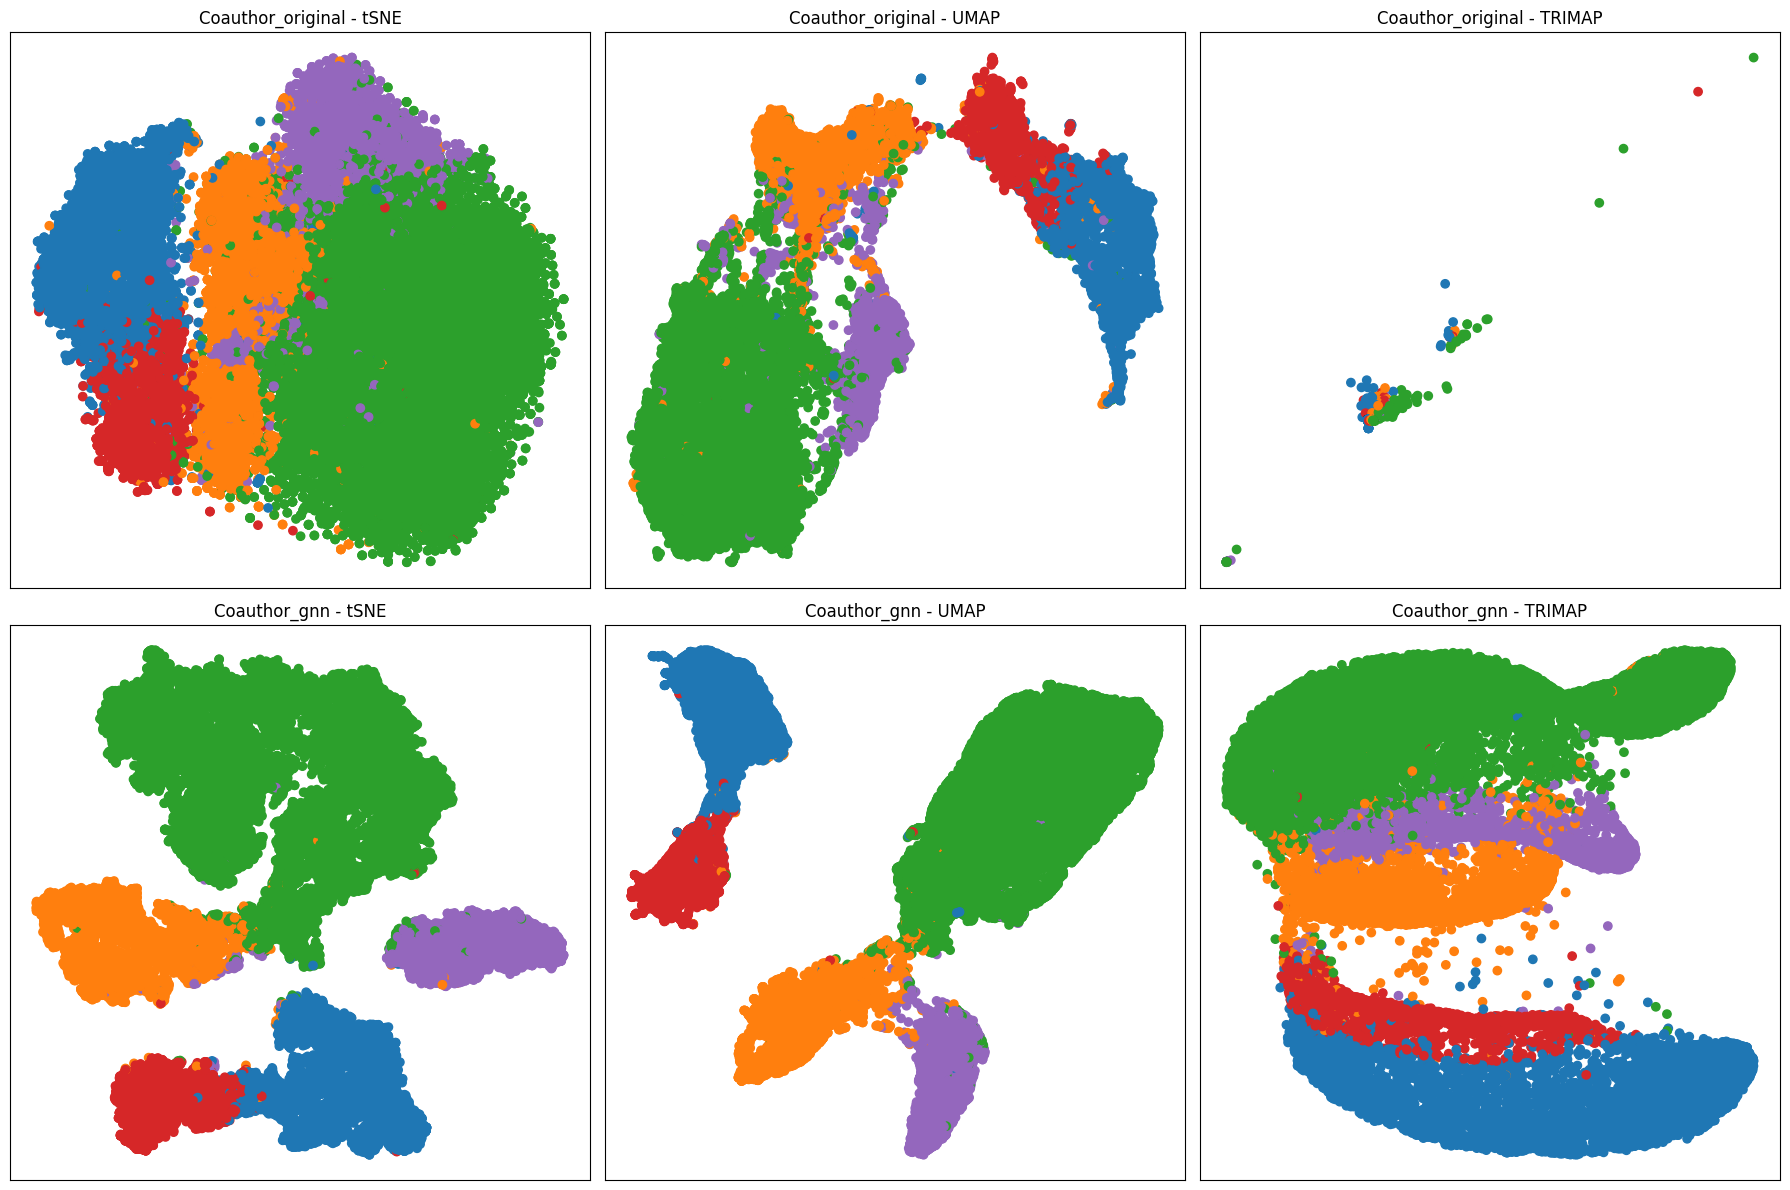

In [5]:
import time
import numpy as np
import torch
from sklearn.manifold import TSNE
import umap
import trimap
import tracemalloc
from memory_profiler import memory_usage
import matplotlib.pyplot as plt
from torch_geometric.datasets import Coauthor
from torch_geometric.data import Data
from torch_geometric.utils import train_test_split_edges
from torch_geometric.nn import GCNConv, GAE
from utils import *
from metrics import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to measure GPU memory usage
def get_gpu_memory():
    return torch.cuda.memory_allocated() / (1024 * 1024)

# Sample data for illustration, replace these with actual data loading and processing
def load_data():
    dataset = Coauthor(root='.', name='Physics', transform=None)
    data = dataset[0]
    return data.x.numpy(), data.y.numpy()

def load_gnn_output():
    dataset = Coauthor(root='.', name='Physics', transform=None)
    data = dataset[0].to(device)

    generate_train_test(data)

    model = GCN(input_dim=dataset.num_node_features, hidden_dim=64, output_dim=16).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Training the GAE model to encode node features into 2D
    print("Training GNN...")
    tracemalloc.start()
    start_time = time.time()
    start_gpu_memory = get_gpu_memory()

    train_loop(200, model, optimizer, data)

    end_time = time.time()
    end_gpu_memory = get_gpu_memory()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    print(f"GNN Training Time: {end_time - start_time:.2f} seconds")
    print(f"RAM Memory usage: Current={current / 1024 / 1024:.2f}MB, Peak={peak / 1024 / 1024:.2f}MB")
    print(f"GPU Memory usage: {end_gpu_memory - start_gpu_memory:.2f}MB")

    # Extract features with the trained GNN
    model.eval()
    with torch.no_grad():
        gnn_output = model(data)

    # Move the features to CPU
    gnn_output = gnn_output.cpu().numpy()

    return gnn_output, data.y.cpu().numpy()



# Load datasets
cora_data, cora_labels = load_data()
gnn_output, gnn_labels = load_gnn_output()


# Initialize subplot
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# Function to apply dimensionality reduction and plot
def apply_dr_and_plot(dataset_name, data, labels, row):
    # tSNE
    tsne_params = params_dict[f"{dataset_name}"]["tSNE"]
    tracemalloc.start()
    start_time = time.time()
    start_gpu_memory = get_gpu_memory()

    tsne = TSNE(metric=tsne_params["metric"], n_iter=tsne_params["n_iter"], perplexity=tsne_params["perplexity"], learning_rate=tsne_params["learning_rate"])
    tsne_results = tsne.fit_transform(data)

    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    end_gpu_memory = get_gpu_memory()
    end_time = time.time()

    print(f"t-SNE ({dataset_name}) Time: {end_time - start_time:.2f} seconds")
    print(f"t-SNE ({dataset_name}) RAM Memory usage: Current={current / 1024 / 1024:.2f}MB, Peak={peak / 1024 / 1024:.2f}MB")
    print(f"t-SNE ({dataset_name}) GPU Memory usage: {end_gpu_memory - start_gpu_memory:.2f}MB")

    plot_no_show(axs[row, 0], tsne_results, labels, f"{dataset_name} - tSNE")

    # UMAP
    umap_params = params_dict[f"{dataset_name}"]["UMAP"]
    tracemalloc.start()
    start_time = time.time()
    start_gpu_memory = get_gpu_memory()

    umap_model = umap.UMAP(metric=umap_params["metric"], min_dist=umap_params["min_dist"], n_neighbors=umap_params["n_neighbors"])
    umap_results = umap_model.fit_transform(data)

    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    end_gpu_memory = get_gpu_memory()
    end_time = time.time()

    print(f"UMAP ({dataset_name}) Time: {end_time - start_time:.2f} seconds")
    print(f"UMAP ({dataset_name}) RAM Memory usage: Current={current / 1024 / 1024:.2f}MB, Peak={peak / 1024 / 1024:.2f}MB")
    print(f"UMAP ({dataset_name}) GPU Memory usage: {end_gpu_memory - start_gpu_memory:.2f}MB")

    plot_no_show(axs[row, 1], umap_results, labels, f"{dataset_name} - UMAP")

    # TRIMAP
    trimap_params = params_dict[f"{dataset_name}"]["TRIMAP"]
    tracemalloc.start()
    start_time = time.time()
    start_gpu_memory = get_gpu_memory()

    trimap_model = trimap.TRIMAP(distance=trimap_params["metric"], n_inliers=trimap_params["n_inliers"], n_iters=trimap_params["n_iters"], n_outliers=trimap_params["n_outliers"], n_random=trimap_params["n_random"])
    trimap_results = trimap_model.fit_transform(data)

    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    end_gpu_memory = get_gpu_memory()
    end_time = time.time()

    print(f"TRIMAP ({dataset_name}) Time: {end_time - start_time:.2f} seconds")
    print(f"TRIMAP ({dataset_name}) RAM Memory usage: Current={current / 1024 / 1024:.2f}MB, Peak={peak / 1024 / 1024:.2f}MB")
    print(f"TRIMAP ({dataset_name}) GPU Memory usage: {end_gpu_memory - start_gpu_memory:.2f}MB")

    plot_no_show(axs[row, 2], trimap_results, labels, f"{dataset_name} - TRIMAP")

# Process Cora_original
apply_dr_and_plot("Coauthor_original", cora_data, cora_labels, 0)

# Process Cora_gnn
apply_dr_and_plot("Coauthor_gnn", gnn_output, gnn_labels, 1)

# Adjust layout
plt.tight_layout()
plt.show()


In [7]:
 %%bash
 python --version

Python 3.10.12


In [8]:
%%bash
nvidia-smi

Mon Jun  3 11:25:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              33W /  70W |   1587MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [9]:
%%bash
lscpu


Architecture:                         x86_64
CPU op-mode(s):                       32-bit, 64-bit
Address sizes:                        46 bits physical, 48 bits virtual
Byte Order:                           Little Endian
CPU(s):                               2
On-line CPU(s) list:                  0,1
Vendor ID:                            GenuineIntel
Model name:                           Intel(R) Xeon(R) CPU @ 2.00GHz
CPU family:                           6
Model:                                85
Thread(s) per core:                   2
Core(s) per socket:                   1
Socket(s):                            1
Stepping:                             3
BogoMIPS:                             4000.34
Flags:                                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 